In [59]:
import pandas as pd
import numpy as np
import arxiv
import os
import networkx as nx
import itertools

In [5]:
client=arxiv.Client()

In [6]:
search = arxiv.Search(
  query = "misinformation",
  max_results = 10000,
  sort_by = arxiv.SortCriterion.SubmittedDate
)

In [7]:
results=client.results(search)

In [8]:
all_results = list(results)

In [9]:
all_results[0]

arxiv.Result(entry_id='http://arxiv.org/abs/2410.18866v1', updated=datetime.datetime(2024, 10, 24, 15, 51, 4, tzinfo=datetime.timezone.utc), published=datetime.datetime(2024, 10, 24, 15, 51, 4, tzinfo=datetime.timezone.utc), title='The Cat and Mouse Game: The Ongoing Arms Race Between Diffusion Models and Detection Methods', authors=[arxiv.Result.Author('Linda Laurier'), arxiv.Result.Author('Ave Giulietta'), arxiv.Result.Author('Arlo Octavia'), arxiv.Result.Author('Meade Cleti')], summary='The emergence of diffusion models has transformed synthetic media generation,\noffering unmatched realism and control over content creation. These\nadvancements have driven innovation across fields such as art, design, and\nscientific visualization. However, they also introduce significant ethical and\nsocietal challenges, particularly through the creation of hyper-realistic\nimages that can facilitate deepfakes, misinformation, and unauthorized\nreproduction of copyrighted material. In response, the

In [42]:
authorship=[]
for authors in all_results:
    author_list=[]
    for i in authors.authors:
        author_list.append(i.name)
    authorship.append(author_list)

In [48]:
authorship[0]

['Linda Laurier', 'Ave Giulietta', 'Arlo Octavia', 'Meade Cleti']

In [49]:
G=nx.Graph()

In [51]:
edges=[]
for val in authorship:
    edges.extend(list(itertools.combinations(val, 2)))

In [55]:
G.add_edges_from(edges)

In [56]:
len(list(G.nodes))

4777

In [57]:
sorted(nx.degree_centrality(G).items(), key=lambda x:x[1], reverse=True)[:5]

[('Preslav Nakov', 0.020309882747068676),
 ('Iason Gabriel', 0.014447236180904523),
 ('Lisa Anne Hendricks', 0.014447236180904523),
 ('Sasha Brown', 0.014447236180904523),
 ('Conor Griffin', 0.014447236180904523)]

In [61]:
average_degree_centrality = np.mean(list(nx.degree_centrality(G).values()))

In [62]:
nodes_to_remove = [node for node, centrality in nx.degree_centrality(G).items() if centrality < average_degree_centrality]
G.remove_nodes_from(nodes_to_remove)

In [65]:
len(list(G.nodes()))

1384

In [74]:
pos=nx.kamada_kawai_layout(G)

{'Preslav Nakov': Text(0.17879355679576592, -0.20986889332342643, 'Preslav Nakov'),
 'Iason Gabriel': Text(-0.020878433383979173, 0.028208017970482197, 'Iason Gabriel'),
 'Lisa Anne Hendricks': Text(-0.07545072091989999, 0.02734779618593781, 'Lisa Anne Hendricks'),
 'Sasha Brown': Text(-0.04500091327775252, 0.021661072316101485, 'Sasha Brown'),
 'Conor Griffin': Text(-0.08420349641618993, 0.03252180879157742, 'Conor Griffin')}

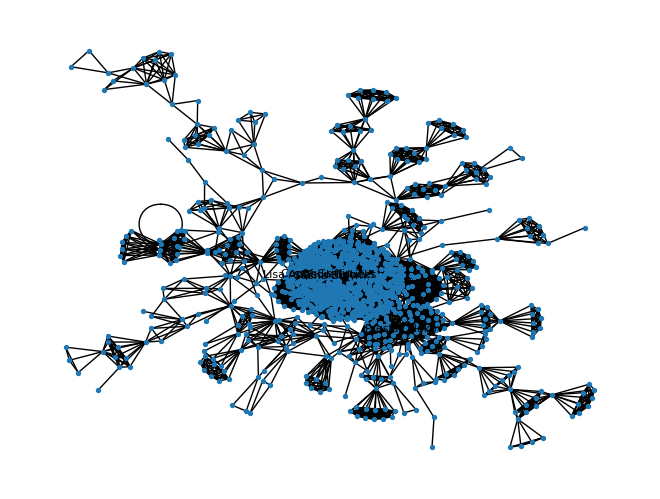

In [76]:
nx.draw(G, pos=pos, node_size=8)
top_5_centrality = sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=True)[:5]
labels = {node: node for node, _ in top_5_centrality}
nx.draw_networkx_labels(G, pos, labels, font_size=8)